# 第9組: 醫電公司合作專案: 
**Author:** 周紘樟、鍾君右、林妤姍、陳亞琦<br>
**Date created:** 2021/11/26<br>
**Last modified:** 2021/11/26<br>

###背景
  - 醫護人員溝通時(包含交接班、巡房、醫師問診等)，常是**一般口語與專業術語夾雜**。
  - 溝通結束後，**醫護人員需額外花時間整理內容，將紀錄中的專業內容提取**並登打到醫院系統中。
  - 若能利用關鍵字抓取技術，**自動將專業術語內容提取出來**，便可以大幅減輕醫療人員文書負擔。

###合作題目
  1. 醫電公司提供逐字稿與欄位資訊，利用文本分析**將逐字稿內容的關鍵字(欄位名稱)自動標記出來**。
  2. 醫電公司提供逐字稿、醫藥辭庫與欄位資訊，利用NLP**將逐字稿的文字內容按欄位類別分類**。

## 大綱
1. 資料前處理
  + 1.1 基本資料介紹
  + 1.2 資料清理
  + 1.3 文章斷句
  + 1.4 文章斷詞
  + 1.5 文字雲
2. 關鍵字標記
  + 2.1 讀取關鍵字對應表格
  + 2.2 關鍵字表格整理
  + 2.3 關鍵字詞搜尋 & 提取
  + 2.4 表格歸納
3. 延伸
  + 3.1 Pairwise Correlation
  + 3.2 POS 詞性標記、NER 命名實體識別
4. 結論    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 移至當前工作目錄
%cd /content/drive/Shareddrives/社媒/醫電

/content/drive/Shareddrives/社媒/醫電


In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
# !wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.font_manager import fontManager

# 改style要在改font之前
# plt.style.use('seaborn')  

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import math
from nltk import ngrams
from nltk import FreqDist
import networkx as nx
from collections import Counter, namedtuple
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import jieba
import jieba.analyse
from wordcloud import WordCloud
from datetime import datetime

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 1. 資料前處理
處理逐字稿的docx檔案，包含資料轉換、斷句與斷詞。

### 1.1 基本資料介紹
- 資料來源: 醫電公司提供之交接班、巡房逐字稿
- 資料集： `raw_data/Doc_Data.csv`
- 資料時間：不明
- 共有190篇逐字稿。
- 內容範例: <br>
<img src="https://imgur.com/dktARGh.png" width="500px" />

**本次文本分析主要針對以下方向:**
1. 標記逐字稿內容的關鍵字(欄位名稱)
2. 將逐字稿的文字內容按交班表格中的欄位類別進行分類，EX:
  - <img src="https://i.imgur.com/6npWjUJ.png" width="400px" />

In [ ]:
#匯入資料
MetaData = pd.read_csv('./raw_data/Doc_Data.csv', encoding='UTF-8')

In [ ]:
print(f"共有 {MetaData.shape[0]} 篇逐字稿") #(row,column)
MetaData.head(1)

共有 190 篇逐字稿


,file_id,dir_name,file_name,content
0,0,1hr_104 ok,1961.docx,現在是七點三十四分然後一六零二病歷號一六九三七五八 一六零五病歷號二零二零五四三 一六零六病...


### 1.2 資料清理  
- 去除NA值
- 將英文字母全部轉換為小寫

In [ ]:
# 移除內容為na值的資料
MetaData.dropna(subset = ["content"], inplace=True)

In [ ]:
#把content欄位的內容轉為string類型
MetaData['content'] = MetaData.content.apply(lambda x: str(x))

In [ ]:
#將英文轉換為小寫
MetaData['content'] = MetaData.content.apply(lambda x: x.lower()) 

### 1.3 文章斷句 
+ 將英文單字之間的空格使用 "_" 連接。
+ 利用空格來將逐字稿斷句 (有的逐字稿沒有標點符號，只有空格)。
+ 利用逗號、問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句。
+ 利用 "然後" ...等口語常用字斷句。


In [ ]:
def cut_sent(para):
    para = re.sub(r'([A-Za-z/])\s([A-Za-z])', r'\1_\2',para) #將英文單字之間的空格替換為"_"，防止被斷句
    para = re.sub(r'([A-Za-z])\s([A-Za-z])', r'\1_\2',para) #將英文單字之間的空格替換為"_"，防止被斷句
    para = re.sub(r'([A-Za-z])-([A-Za-z])', r'\1_\2',para) #將英文單字之間的"-"符號替換為"_"，防止被斷句
    para = re.sub(r'([A-Za-z])\s([\u4e00-\u9fa5])', r'\1_\2',para) #將英文+中文之間的空格替換為"_"，防止被斷句
    para = re.sub(r'[(?)]','', para) #去除逐字稿內的(?)符號(推測該符號代表無法辨識的文字)
    para = re.sub(r'[()（）⋯]+','', para) #去除特殊符號
    para = re.sub('([。!！？\?；;，,])([^”’])', r"\1\n\2", para)  # 斷句符號
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號
    para = re.split("。|，|,|然後| |\r|[\n]+",para) # 找到一個或多個\n，空格，"然後"，逗號和句號 都可以斷句
    para_list = list(filter(None, para))
    return para_list 

In [ ]:
# 把句子切開
MetaData['sentence'] = MetaData.apply(lambda row : cut_sent(row['content']), axis = 1)
MetaData.head(3)

,file_id,dir_name,file_name,content,sentence
0,0,1hr_104 ok,1961.docx,現在是七點三十四分然後一六零二病歷號一六九三七五八 一六零五病歷號二零二零五四三 一六零六病...,"[現在是七點三十四分, 一六零二病歷號一六九三七五八, 一六零五病歷號二零二零五四三, 一六..."
1,1,1hr_104 ok,1962.docx,八七零二就一個病歷號 二一四八六四五他是懷孕三五加五prom twis c/s第一胎 g o...,"[八七零二就一個病歷號, 二一四八六四五他是懷孕三五加五prom_twis_c/s第一胎, ..."
2,2,1hr_104 ok,1966.docx,來八七零二病歷號二一四八六四五喔齁這個呢懷孕三五加五然後prom twins c/s第一胎g...,"[來八七零二病歷號二一四八六四五喔齁這個呢懷孕三五加五, prom_twins_c/s第一胎..."


In [ ]:
# 將sentence欄位展開
MetaData_sent = MetaData[['file_id','file_name','sentence']].explode('sentence')

In [ ]:
# 看看有幾個句子
print(f"total sentences: {MetaData_sent.shape[0]}")
MetaData_sent.head(100)

total sentences: 54338


,file_id,file_name,sentence
0,0,1961.docx,現在是七點三十四分
0,0,1961.docx,一六零二病歷號一六九三七五八
0,0,1961.docx,一六零五病歷號二零二零五四三
0,0,1961.docx,一六零六病歷號二一九一八零零零零
0,0,1961.docx,一六零七病歷號二一六二八零七
...,...,...,...
0,0,1961.docx,好
0,0,1961.docx,就這樣子
0,0,1961.docx,一千昨天的一千沒有滴完因為spinal麻怕他尿不出來所以先收line早上就直接掛上去
0,0,1961.docx,就cefa打跟口服藥吃purfen因為他有pca所以那個morphine沒打過vital_s...


In [ ]:
MetaData_sent[MetaData_sent['file_name']== '1041.docx'].head() #有標點符號的逐字稿內容

,file_id,file_name,sentence
93,93,1041.docx,一六三二
93,93,1041.docx,林聰
93,93,1041.docx,治病號五六五七四零
93,93,1041.docx,左邊femoral_fracture的
93,93,1041.docx,他就一樣沒事


### 1.4 文章斷詞
- 使用`jieba`套件進行斷詞與移除停用字
- 加入自訂中、英文醫學專有名詞、藥學專有名詞辭典
- 加入自訂停用字

In [ ]:
# 讀取英文醫學專有名詞字典，並進行文字處理(符號替換、英文字母轉小寫)
with open('./dict/ENG.txt',encoding="utf-8") as f:
  # 將英文單字之間的空格替換為"_"，防止被斷詞，並將英文字母都轉為小寫
  words = [ re.sub(r'([A-Za-z])\s([A-Za-z])', r'\1_\2',line.strip().lower()) for line in f.readlines()] 

for word in words:
  jieba.add_word(word) # 新增英文醫學專有名詞到jieba

In [ ]:
# 讀取藥學專有名詞字典，並進行文字處理(符號替換、英文字母轉小寫)
with open('./dict/medicine_dict.txt',encoding="utf-8") as f:
  med_words = []
  for line in f.readlines():
    word = line.strip().lower() # 將英文字母都轉為小寫
    word = re.sub(r'{.*}', r'', word) #將中括號，以及{}內的文字刪除
    word = re.sub(r'([A-Za-z])\s([A-Za-z])', r'\1_\2', word) # 將英文單字之間的空格替換為"_"，防止被斷詞
    med_words.append(word)

for word in med_words:
  jieba.add_word(word) # 新增藥學專有名詞到jieba

In [ ]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/user_dict.txt')
#新增中文醫學專有名詞辭典
jieba.load_userdict('./dict/中文合併.txt')

#新增stop words
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
    
# 參數形式手動加入停用字
user_stop = ["再來","喔齁","這是","給他","東西","就給","那個","就是","好的","反正","今天","昨天","早上","明天", "就樣"]
for i in user_stop:
    stopWords.append(i)

Building prefix dict from /content/drive/Shareddrives/社媒/醫電/dict/dict.txt.big ...
Loading model from cache /tmp/jieba.ub779cf9769b59125081767eaff77a1ee.cache
Loading model cost 1.462 seconds.
Prefix dict has been built successfully.


In [ ]:
def getToken(row):
    
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選出不在停用字的字
    return seg_list

In [ ]:
MetaData_sent['word'] = MetaData_sent.sentence.apply(getToken)

In [ ]:
MetaData_sent.head()

,file_id,file_name,sentence,word
0,0,1961.docx,現在是七點三十四分,"[七點, 三十四]"
0,0,1961.docx,一六零二病歷號一六九三七五八,"[六零, 病歷號, 六九, 三七, 五八]"
0,0,1961.docx,一六零五病歷號二零二零五四三,"[六零, 病歷號, 二零二零, 五四三]"
0,0,1961.docx,一六零六病歷號二一九一八零零零零,"[六零, 病歷號, 二一, 九一八, 零零, 零零]"
0,0,1961.docx,一六零七病歷號二一六二八零七,"[六零, 病歷號, 二一六, 二八, 零七]"


In [ ]:
Meta_word= MetaData_sent.explode('word') # 展開 word 欄位

### 1.5 文字雲

In [ ]:
# 針對不同file畫出該file的文字雲
def wc_dict(df, id, countB, countS):
    # query(): 查詢DataFrame的col
    wc_df = (df.query("file_id == @id") # 篩選id
                .query("size < @countB") # 篩選MAX
                .query("size > @countS") # 篩選min
                .sort_values("size", ascending = False))
    # 建成dictionary
    wc_dict = dict(zip(wc_df["word"], wc_df["size"]))
    return wc_dict

In [ ]:
# 整體文字雲
def wc_dict2(df, countB, countS):
    # query(): 查詢DataFrame的col
    wc_df = (df.query("size < @countB") # 篩選MAX
                .query("size > @countS") # 篩選min
                .sort_values("size", ascending = False))
    # 建成dictionary
    wc_dict = dict(zip(wc_df["word"], wc_df["size"]))
    return wc_dict

In [ ]:
# 計算每個id不同詞的頻率，將id和word分到同一組

# size(): number of rows in each group as a DataFrame(as_index=False)
word_count = Meta_word.groupby(["file_id", "word"], as_index = False).size()

# word_count，用size排序
word_count.sort_values(by = ["size"], ascending = False, inplace = True)

# 過濾出現太少次的詞
word_count = word_count[word_count["size"] > 3]
word_count

,file_id,word,size
23548,64,ok,33
31994,86,ok,28
42625,115,沒事,28
56578,153,vital_sign,26
20171,56,on,24
...,...,...,...
59377,160,keto,4
36588,98,wound,4
12683,32,零八,4
61982,166,q六,4


單一檔案的文字雲，以file_id = 86為例。

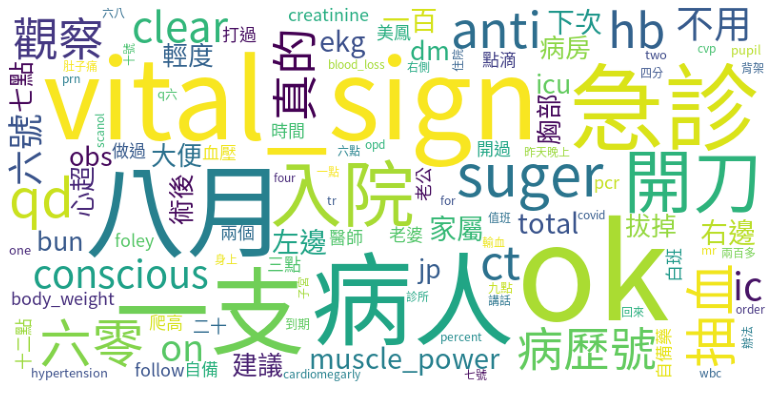

In [ ]:
id_86 = wc_dict(word_count, 86, 200, 0)

font = 'SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color = "white", width = 800, height = 400, font_path = font, colormap = "viridis")
wordcloud.generate_from_frequencies(id_86)

plt.figure(figsize = (14, 7))
# display data as an image
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
word_count_all = Meta_word.groupby(["word"], as_index = False).size()

# word_count，用size排序
word_count_all.sort_values(by = ["size"], ascending = False, inplace = True)

# 過濾出現太少次的詞
word_count_all = word_count_all[word_count_all["size"] > 3]
word_count_all

,word,size
2358,vital_sign,1414
1573,ok,1039
10336,病歷號,961
8029,抽血,833
445,cath,768
...,...,...
8640,早期,4
9662,淡紅,4
14134,食物,4
8637,早安,4


整個文集的文字雲

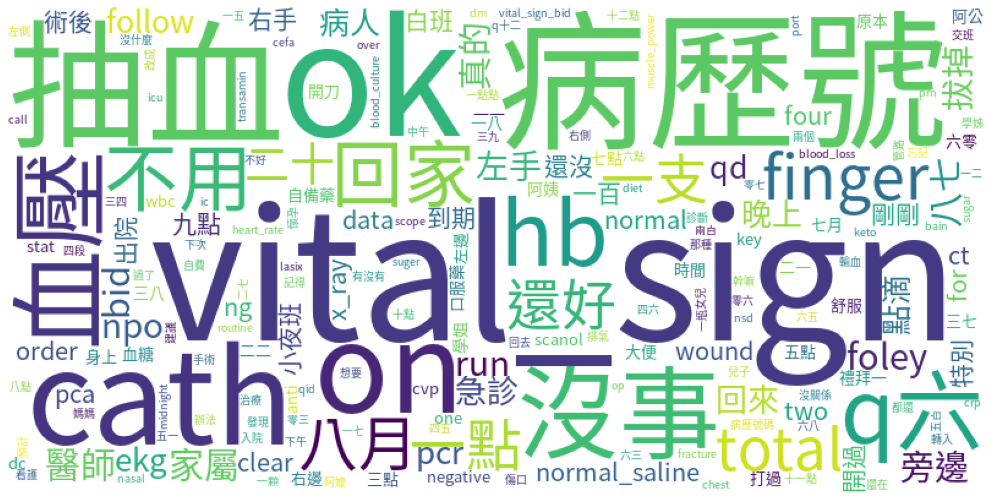

In [ ]:
all = wc_dict2(word_count_all, 1600, 100)

font = 'SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color = "white", width = 800, height = 400, font_path = font, colormap = "viridis")
wordcloud.generate_from_frequencies(all)

plt.figure(figsize = (20, 9))
# display data as an image
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

*透過反覆觀察整個文集的文字雲，進行斷詞的修正。*

## 2. 關鍵字標記
依據醫電公司提供的關鍵字表格，
提取句子中的關鍵字，並分類至對應的護理欄位類別
+ **護理欄位&逐字稿關鍵字詞範例 :**
  + 「住院履歷」 : 住院履歷、樓、病房
  + 「飲食」 : 飲食、diet
  + 「生命徵象」 : 生命徵象、Vital sign、體溫、脈搏、Heart rate...等。



### 2.1 讀取關鍵字對應表格

In [ ]:
#匯入關鍵字對應表格資料
Keyword = pd.read_csv('./raw_data/Keyword_table.csv', encoding='UTF-8')

In [ ]:
Keyword.head(3)

,category_id,Column,keyword
0,1.0,診斷,診斷
1,2.0,入院經過,入院經過
2,3.0,住院履歷,住院履歷\n樓\n病房


### 2.2 關鍵字表格處理
- 去除NA值
- 將英文字母全部轉換為小寫
- 利用"換行符號"分割表格中的關鍵字詞 (例如:住院履歷\n樓\n病房 -> 住院履歷, 樓, 病房)

In [ ]:
# 移除內容為na值的資料
Keyword.dropna(subset = ["category_id"], inplace=True)

In [ ]:
#將keyword欄位轉為string
Keyword['keyword'] = Keyword.keyword.apply(lambda x: str(x))
#將所有英文字轉為小寫
Keyword['keyword'] = Keyword.keyword.apply(lambda x: x.lower())
#category_id欄位轉為int
Keyword['category_id'] = Keyword.category_id.apply(lambda x: int(x))

In [ ]:
def split_word(para):
    para = re.split("\n",para) # 利用\n分割關鍵字詞
    para_list = list(filter(None, para))
    return para_list

In [ ]:
#利用\n將關鍵字詞轉為list
Keyword['keyword_list'] = Keyword.apply(lambda row: split_word(row['keyword']), axis = 1)

In [ ]:
Keyword.head(11)

,category_id,Column,keyword,keyword_list
0,1,診斷,診斷,[診斷]
1,2,入院經過,入院經過,[入院經過]
2,3,住院履歷,住院履歷\n樓\n病房,"[住院履歷, 樓, 病房]"
3,4,飲食,飲食\ndiet,"[飲食, diet]"
4,5,住院史,住院史\n住院原因,"[住院史, 住院原因]"
5,6,手術史,手術史\n手術原因,"[手術史, 手術原因]"
6,7,病史,過去病史\n病史,"[過去病史, 病史]"
7,8,過敏史,藥物過敏\n食物過敏\n過敏史\n過敏\n不能吃\n不可以吃,"[藥物過敏, 食物過敏, 過敏史, 過敏, 不能吃, 不可以吃]"
8,9,生命徵象,生命徵象\nvital sign\n體溫\n脈搏\nheart rate \n呼吸\n血壓\...,"[生命徵象, vital sign, 體溫, 脈搏, heart rate , 呼吸, 血壓..."
9,10,管路,管路\ncatheter\niv cath\ncath \npermcath\nfoley ...,"[管路, catheter, iv cath, cath , permcath, foley..."


### 2.2 關鍵字詞搜尋 & 提取
- 將先前加入英文字之間的底線還原為空格
- 搜尋並提取各個護理欄位的關鍵句子

In [ ]:
MetaData_table = MetaData_sent.copy()

In [ ]:
#將英文字之間的底線還原為空格
MetaData_table['sentence'] = MetaData_table.sentence.apply(lambda x : re.sub("_"," ",x)) 

In [ ]:
Keyword['sentence_list'] = ""

In [ ]:
# #搜尋並提取各個護理欄位的關鍵句子
# for i in range(0,Keyword.shape[0]):
#   toMatch = '|'.join(Keyword['keyword_list'][i])
#   sentence = list(MetaData_table[MetaData_table.sentence.str.contains(toMatch)]['sentence']) #找出有包含關鍵字詞的句子
#   Keyword['sentence_list'][i] = sentence #將篩選出的句子放進sentence_list欄位

### 2.3 表格歸納
- 製作各個逐字稿檔案的表格

In [ ]:
#把上面搜尋&提取欄位關鍵字的程式寫成function
def get_table(file_data):
  #建立表格
  df_table = pd.DataFrame(columns = ['category_id','column','sentence_list'])
  
  #搜尋並提取各個護理欄位的關鍵句子
  for i in range(0,Keyword.shape[0]):
    toMatch = '|'.join(Keyword['keyword_list'][i])
    sentence = list(file_data[file_data.sentence.str.contains(toMatch)]['sentence']) #找出有包含關鍵字詞的句子

    #新增資料到DataFrame
    df_table = df_table.append( pd.DataFrame([(Keyword['category_id'][i], Keyword['Column'][i], sentence)],
                            columns = ['category_id','column','sentence_list']),ignore_index=True)
  return df_table

In [ ]:
#製作各個檔案的表格，以file_id=2的檔案為例
file_2 = MetaData_table[MetaData_table['file_id'] == 2]
table_2 = get_table(file_2)

In [ ]:
table_2

,category_id,column,sentence_list
0,1,診斷,[齁術後診斷是multiple uterine myoma加左側ovarian endome...
1,2,入院經過,[]
2,3,住院履歷,[]
3,4,飲食,[]
4,5,住院史,[]
5,6,手術史,[]
6,7,病史,[]
7,8,過敏史,[]
8,9,生命徵象,[不結紮不退奶轉床舊病歷都有vital sign就我們q four測i/o total二十四...
9,10,管路,[已經可以喝水囉齁自費pca防沾水性傷口敷料左手的兩個cath一個就點滴一個pca這樣子fo...


In [ ]:
#把sentence_list欄位裡面的句子之間加入換行符號
table_2['sentence'] = table_2.sentence_list.apply(lambda x: "\n".join(x))

In [ ]:
#表格結果輸出成csv檔
table_2.to_csv('./table_2.csv', index = False)

**輸出表格範例圖:** <br>

<img src="https://imgur.com/Az2nz7O.png" width="800px" />

## 3. 延伸
以醫電提供的逐字稿資料，進行pairwise correlation、NER、POS分析，來優化斷詞。



### 3.1 Pairwise correlation

In [ ]:
#計算各詞彙在各file中出現的次數
word_count_per_doc = Meta_word.groupby(['file_id','word'],as_index=False).size()
word_count_per_doc.rename(columns={'size': 'count'}, inplace=True)
word_count_per_doc

,file_id,word,count
0,0,ankle,2
1,0,ankle_fracture,2
2,0,appendicitis,2
3,0,bag,1
4,0,bfluid,1
...,...,...,...
70852,189,顏色,1
70853,189,餅乾,1
70854,189,體重,2
70855,189,鮮血,1


- 進行bigram，並計算兩個詞彙間的相關性 Phi相關係數(Phi coefficient)  

In [ ]:
# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    if (len(seg_list) >1):
      bigramfdist.update(ngrams(seg_list, 2))
      seg_list2 = ngrams(seg_list, 2)
      seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [ ]:
doc_bigram2 = MetaData_sent.copy()
doc_bigram2["word"] = doc_bigram2.sentence.apply(bigram_getToken_dict)

In [ ]:
# 看一下bigramfdist內容
bigramfdist.most_common(5)

[(('vital_sign', 'q六'), 308),
 (('vital_sign', 'bid'), 175),
 (('vital_sign', 'four'), 175),
 (('vital_sign', 'ok'), 149),
 (('finger', '四段'), 124)]

In [ ]:
print(bigramfdist)

<FreqDist with 50613 samples and 74749 outcomes>


In [ ]:
#取出前1000筆的bigram pair
b = {k:v for k,v in bigramfdist.most_common(1000)}
b.items()

dict_items([(('vital_sign', 'q六'), 308), (('vital_sign', 'bid'), 175), (('vital_sign', 'four'), 175), (('vital_sign', 'ok'), 149), (('finger', '四段'), 124), (('midnight', 'npo'), 99), (('身上', '管路'), 93), (('病歷號', '二一'), 89), (('ekg', 'nsr'), 83), (('cath', '一支'), 73), (('cath', '左手'), 66), (('pcr', 'negative'), 66), (('cath', 'on'), 64), (('病歷號', '二二'), 63), (('都還', 'ok'), 61), (('cath', '右手'), 60), (('hb', '九點'), 59), (('on', 'call'), 58), (('抽血', 'data'), 54), (('血壓', 'ok'), 51), (('chest', 'x_ray'), 50), (('左手', '二十'), 49), (('vital_sign', 'qid'), 49), (('day', 'total'), 48), (('foley', '二十四小時'), 45), (('normal_saline', '五百'), 44), (('finger', 'q六'), 44), (('病歷號', '二零'), 44), (('bacteria', '一價'), 43), (('辦好', '回家'), 43), (('病歷號', '一八'), 42), (('one', 'one'), 42), (('foley', '拔掉'), 42), (('hb', '十點'), 41), (('hb', '八點'), 41), (('右手', '二十'), 40), (('嬰兒', '餵奶'), 40), (('骨盆', 'ct'), 40), (('不用', '不用'), 40), (('x_ray', 'normal'), 40), (('sip', 'water'), 40), (('不用', 'total'), 39), (('hb',

In [ ]:
#建立DataFrame
bigram_df = pd.DataFrame(columns=['word', 'word2','n'])
for k,v in b.items():
    bigram_df = bigram_df.append({'word':k[0], 'word2':k[1], 'n':v}, ignore_index=True)

In [ ]:
bigram_df

,word,word2,n
0,vital_sign,q六,308
1,vital_sign,bid,175
2,vital_sign,four,175
3,vital_sign,ok,149
4,finger,四段,124
...,...,...,...
995,calm,down,6
996,病歷號碼,零七,6
997,血壓,藥吃,6
998,寶寶,嬰兒,6


In [ ]:
#計算phi值
def phi_cor(df):
    #total x
    nx = len(set(word_count_per_doc[word_count_per_doc["word"]==df["word"]]["file_id"]))
    tnx = len(MetaData)-nx
    #total y
    ny = len(set(word_count_per_doc[word_count_per_doc["word"]==df["word2"]]["file_id"]))
    tny = len(MetaData)-ny
    #有x 有y
    x_ls = list(word_count_per_doc[word_count_per_doc["word"]==df["word"]]["file_id"]) #單獨有x
    y_ls = list(word_count_per_doc[word_count_per_doc["word"]==df["word2"]]["file_id"]) #單獨有y
    nxy = len(set(x_ls)&set(y_ls)) #取交集
    #有x 沒有y
    nxo = nx-nxy
    #沒有x 沒有y
    uxy = set(x_ls)|set(y_ls) #取聯集
    noo = len(set(list(MetaData["file_id"]))-uxy) #取差集:全-有x有y
    #沒有x 有y
    noy = ny-nxy
    #print(nx,ny,tny,tnx,nxy,noo,nxo,noy)
    phi = (nxy*noo-nxo*noy)/math.sqrt(nx*ny*tny*tnx)
    
    return phi

In [ ]:
bigram_df["cor"] = bigram_df.apply(phi_cor, axis=1)
bigram_df = bigram_df[bigram_df["word"]!=bigram_df["word2"]]

In [ ]:
bigram_df.sort_values(by='cor', ascending=False)

,word,word2,n,cor
799,whole,body,7,1.000000
817,international,unit,7,1.000000
371,初次,罹癌,12,0.954734
415,go,home,11,0.946044
366,規則,痛經,12,0.920575
...,...,...,...,...
950,一三五,八七,6,-0.127273
500,沒事,辦好,9,-0.129214
119,病歷號,一二,22,-0.148542
627,六七,病歷號,8,-0.190909


- 使用詞彙關係圖畫出相關性大於0.7的組合

In [ ]:
bigram_df[bigram_df["cor"]>0.7].sort_values(by='cor', ascending=False).head(10)

,word,word2,n,cor
799,whole,body,7,1.000000
817,international,unit,7,1.000000
371,初次,罹癌,12,0.954734
415,go,home,11,0.946044
366,規則,痛經,12,0.920575
254,vital,sing,15,0.907757
782,預立,安寧,7,0.892007
46,nsd,第一胎,38,0.879997
985,asthma,噴劑,6,0.835056
357,free,charge,12,0.825389


以上列出correlation>0.7中的前十個詞彙組合，可以看到"初次 罹癌"等相關性高的組合。<br>
當中出現"vital sing"的組合，或許可以做為醫電修改語音辨識的參考。

In [ ]:
word_cors = bigram_df[bigram_df["cor"]>0.7].sort_values(by='cor', ascending=False)
word_cors.reset_index(inplace=True, drop=True)

In [ ]:
import networkx as nx
# Create network plot 
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(word_cors)):
    g.add_edge(word_cors["word"][i], word_cors["word2"][i], weight=word_cors["cor"][i])
    
# 取得edge權重
weights = [w[2]['weight']*5 for w in  g.edges(data=True)]

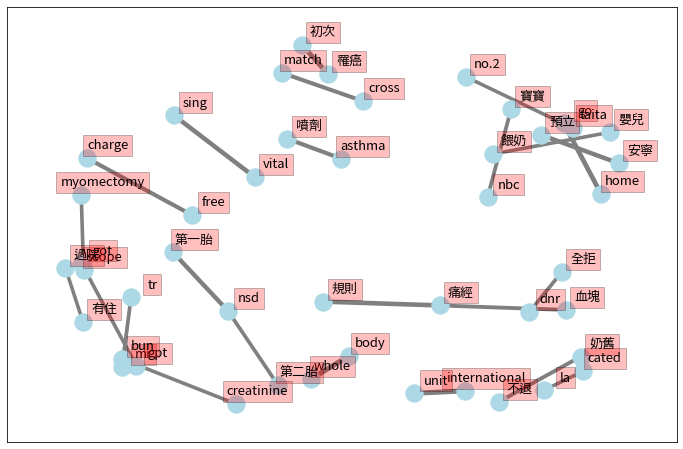

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.5)

# networks
nx.draw_networkx(g, pos,
                 font_size=14,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

我們透過反覆觀察網路圖的狀態、correlation，新增user_dict，優化斷詞的效果。<br>
目前correlation>0.7的組合數量已大幅下降，可以作為我們斷詞優化的成果。

### 3.2 POS(詞性標記)、NER(命名實體識別)



#### CKIP安裝

In [ ]:
% pip install ckiptagger

In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator
import tweepy as tw

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [ ]:
#data_utils.download_data_gdown("./") # gdrive-ckip # 下載ckip model

In [ ]:
# # To use CPU:
# ws = WS("./data")
# pos = POS("./data")
# ner = NER("./data")

In [ ]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['sentence']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2) # set dictionary 
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['file_id'],sentence])            
            temp_tokens = get_pos(row['file_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['file_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['file_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['file_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['file_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [ ]:
# 自定義辭典
with open('./dict/醫學.txt') as f:
    lines = f.read().splitlines()

dict_harry = {k: 1 for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict_harry)

#### 將抓取結果用coreNLP進行處理

In [ ]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=True, keep_alphabets=True):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字、英文
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

In [ ]:
# pos_table, entity_table, sentence_table = get_nlp_result(MetaData_sent)

#### 欄位名稱介紹

pos_table
> + file_id : 記錄檔編號

> + word : 原始斷詞

> + pos : part-of-speech,詞性

ner_table


> + file_id : 記錄檔編號


> + word: 原始斷詞


> + ner: 命名實體

sentence_table


> + file_id : 記錄檔編號

> + sentence : 原始斷句















In [ ]:
#結果輸出csv檔
# pos_table.to_csv('./pos_table_medical.csv', index = False)
# entity_table.to_csv('./entity_table_medical.csv', index = False)
# sentence_table.to_csv('./sentence_table_medical.csv', index = False)

In [ ]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("./pos/pos_table_medical.csv") 
entity_table = pd.read_csv("./pos/entity_table_medical.csv") 
sentence_table = pd.read_csv("./pos/sentence_table_medical.csv") 

In [ ]:
pos_table.head(5) # word pos 列表

,file_id,word,pos
0,0,現在,Nd
1,0,是,SHI
2,0,七點,Nd
3,0,三十四分,Nd
4,0,一六零二,Neu


In [ ]:
entity_table.head(5) # word entity 列表

,file_id,word,ner
0,0,七點三十四分,TIME
1,0,今天,DATE
2,0,早上,TIME
3,0,早上,TIME
4,0,昨天,DATE


In [ ]:
# 檢查筆數正不正確
print(f"total posts numbers: {len(pos_table['file_id'].unique())}")
print(f"posts have NER: {len(entity_table['file_id'].unique())}") 

total posts numbers: 189
posts have NER: 189


#### NER 種類分析  
查看標註這個文集後辨識出哪一些實體種類

In [ ]:
entity_table['ner'].unique()

array(['TIME', 'DATE', 'CARDINAL', 'NORP', 'PERSON', 'MONEY', 'ORDINAL',
       'GPE', 'PRODUCT', 'LANGUAGE', 'QUANTITY', 'WORK_OF_ART', 'FAC',
       'LOC', 'ORG', 'EVENT', 'PERCENT'], dtype=object)

##### 每個一個種類的數量

In [ ]:
ner_count = entity_table.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
1,DATE,7826
0,CARDINAL,4598
12,PERSON,2898
15,TIME,2824
9,ORDINAL,635
4,GPE,305
14,QUANTITY,224
5,LANGUAGE,149
10,ORG,102
8,NORP,58


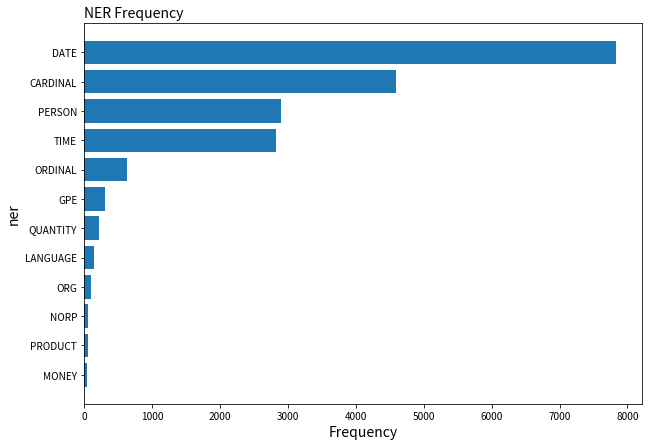

In [ ]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

##### 涉及到的人名(PERSON)

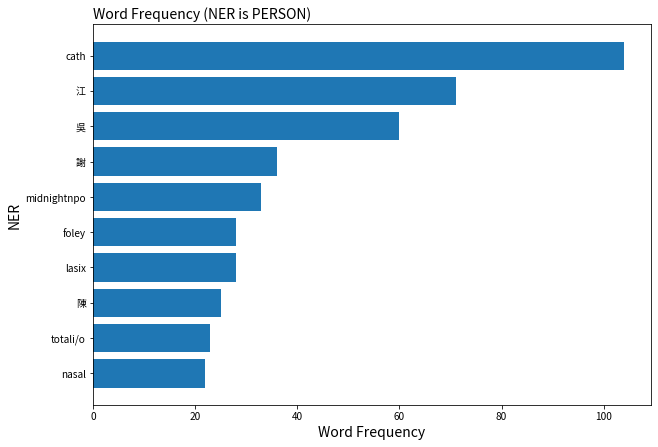

In [ ]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

看一下含特定關鍵字的內容

In [ ]:
keyword_list = ['阿長','江']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關句子")
select.head(10)

#### POS 種類分析  
查看辨識出哪幾種POS  

POS 詞性列表:
中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/ 

+ Na: 普通名詞  
+ D: 副詞  
+ VC: 動作及物動詞  
+ Nb: 專有名詞  
+ FW: 外文  
+ VH: 狀態不及物動詞  
+ Nh: 代名詞  
+ DE: 的之得地  
+ P: 介詞  
+ VA: 動作不及物動詞  
+ T: 語助詞  
+ SHI: 是

In [ ]:
pos_table['pos'].unique()

array(['Nd', 'SHI', 'Neu', 'Na', 'Nb', 'Nep', 'Nf', 'D', 'VC', 'Di', 'P',
       'VJ', 'VH', 'DE', 'FW', 'Nh', 'Ncd', 'T', 'Cbb', 'VCL', 'VB', 'VE',
       'I', 'VA', 'VK', 'VD', 'Caa', 'V_2', 'Dfa', 'VG', 'Nc', 'Dfb',
       'Cab', 'Ng', 'VF', 'Neqa', 'VL', 'Da', 'Cba', 'Nes', 'VI', 'DM',
       'Nv', 'A', 'VAC', 'Neqb', 'Dk', 'VHC', 'COMMACATEGORY',
       'PERIODCATEGORY', 'PAUSECATEGORY'], dtype=object)

##### 每個詞性的數量

In [ ]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
pos_count

,pos,count
5,D,50663
13,FW,42873
27,Nh,31202
15,Na,30071
36,VC,23844
42,VH,17940
24,Neu,17638
32,T,14506
29,P,13875
19,Nd,13622


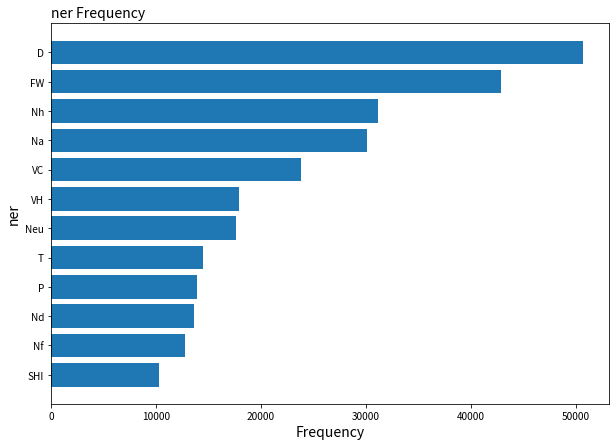

In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

##### 涉及到的普通名詞(Na)


In [ ]:
# 篩選pos為名詞的資料
l_noun = ["Na"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前13個
# 寫法一
noun_count = noun.groupby('word')['word'].agg(['count'])
noun_count = noun_count.sort_values(['count'],ascending=False)['count'].nlargest(15).reset_index()
noun_count.head(10)

,word,count
0,班,1156
1,時候,1037
2,事,753
3,話,568
4,血壓,560
5,血,552
6,藥,528
7,病,466
8,醫師,409
9,家屬,377


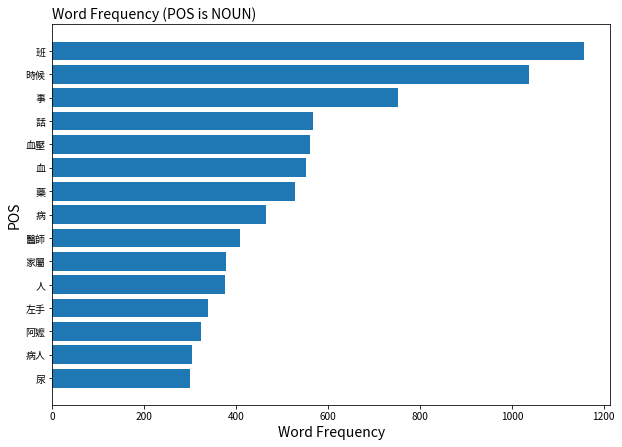

In [ ]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

看一下含特定關鍵字的內容

In [ ]:
keyword_list = ['醫師','血壓']
select = sentence_table[sentence_table['sentence'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{select.shape[0]}篇相關句子")
select.head(10)

醫師 血壓：1062篇相關句子


,file_id,sentence
18,0,早上血壓一一八over七十九heartrate五十五就cath就是你昨天on的右下右手那個e...
137,0,血壓都早上比較高他昨天早上就比較高了一五二八二heartrate六十二六十八啦cath你就o...
211,0,齁就這樣他每天早上都會給我演這一齣就這樣heartrate快啦反正就是因為他就喘反正血壓一零...
263,1,反正他的血壓一入院的時候一五六九一啦我們班剛剛量兩次一次一五零九零一次一五八九六齁但是都沒有...
290,1,他還叫吳醫師跟仲介講電話
291,1,吳醫師還跟仲介講說呃我們是預計十一點開刀結果就真的十一點送
305,1,他自備他自備的血壓藥我已經早上給完我就還給他囉
358,2,我有跟吳醫師說他說可能是hematoma
373,2,反正吳醫師知道他說就在看看所以你要看會不會變更腫或紫紫的齁他動作沒有特別大或蹲他都說沒有
464,3,本身高血壓是esrddm


### 4. 結論
完成根據關鍵字將文集放入正確的欄位。

#### **挑戰與限制**
在本次的合作專案中，我們針對醫電公司所提供的逐字稿資料進行了大量的文字預處理，但由於資料內容較為口語化、中英夾雜、部分逐字稿沒有標點符號斷句...等問題，分析過程中遇到了許多困難點。

針對 **資料** 的部分，我們進行了以下處理: <br>
+ **整體資料**
  + 去除空值
  + 將英文字母全部轉換為小寫 <br>
+ **逐字稿斷句**
  + 將英文單字之間的空格使用 "_" 連接。
  + 利用空格來將逐字稿斷句 (有的逐字稿沒有標點符號，只有空格)。
  + 利用逗號、問號、句號或驚嘆號等符號斷句，或是如果出現中文或是英文的省略號，像是`...`也會斷句。
  + 利用 "然後" ...等口語常用字斷句。

**關鍵字**部分遇到的困難:
+ 由於我們並不具備醫學相關的知識，無法確定各個欄位的關鍵字有哪些，並且考慮到一個句子當中可能會有複數個欄位的關鍵字，無法僅根據字詞間的correlation做出判斷，因此難以進行欄位關鍵字的擴充。

#### **建議**
+ 建議可以統一病例的敘述方式，如口述病歷號XXXX後，接續該病例的內容，部分醫護人員會先敘述所有需要紀錄的病歷號後，再口述各個病例的內容，或是相互穿插各病人的紀錄，在文本分析上較為複雜，因此建議可以統一格式，對於後續資料的處理上會較為容易。
+ 建議可以都將逐字稿加上標點符號，部分檔案完全沒有標點符號，導致在文章斷句的部分遇到很大的困難，在後續資料上會需要較多的人工處理，日後若要全自動化會遇到許多阻礙。
